# Polinomial Regression

In [108]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [109]:
# Load data
X_train = np.load("Data/X_train.npy")
Y_train = np.load("Data/Y_train.npy")

print(X_train.shape)
print(Y_train.shape)

(700, 6)
(700,)


In [110]:
# Test polynomial degrees from 1 to 10
for degree in range(1, 11):
    # Generate polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X_train)
    
    print(f"Degree {degree}: X_poly shape = {X_poly.shape}")
    
    # Fit regression model
    model = LinearRegression()
    model.fit(X_poly, Y_train)
    
    # Predict on training data
    Y_pred = model.predict(X_poly)
    
    # Compute R^2
    r2 = r2_score(Y_train, Y_pred)
    
    print(f"Degree {degree}: R^2 = {r2:.4f}\n")

Degree 1: X_poly shape = (700, 6)
Degree 1: R^2 = 0.5600

Degree 2: X_poly shape = (700, 27)
Degree 2: R^2 = 0.8298

Degree 3: X_poly shape = (700, 83)
Degree 3: R^2 = 0.8832

Degree 4: X_poly shape = (700, 209)
Degree 4: R^2 = 0.9817

Degree 5: X_poly shape = (700, 461)
Degree 5: R^2 = 0.9959

Degree 6: X_poly shape = (700, 923)
Degree 6: R^2 = 0.9998

Degree 7: X_poly shape = (700, 1715)
Degree 7: R^2 = 1.0000

Degree 8: X_poly shape = (700, 3002)
Degree 8: R^2 = 0.9999

Degree 9: X_poly shape = (700, 5004)
Degree 9: R^2 = 0.9994

Degree 10: X_poly shape = (700, 8007)
Degree 10: R^2 = 0.9983



Split the data into train set (600 entries) and test set (100 entries)

In [111]:
# Load data
X_train_input = np.load("Data/X_train.npy")  # shape (700, 6)
Y_train_input = np.load("Data/Y_train.npy")  # shape (700,)
    
# Split data: first 500 train, last 200 test
X_train, X_test = X_train_input[:600], X_train_input[600:]
Y_train, Y_test = Y_train_input[:600], Y_train_input[600:]

print("Train shape:", X_train.shape, Y_train.shape)
print("Test shape:", X_test.shape, Y_test.shape)


Train shape: (600, 6) (600,)
Test shape: (100, 6) (100,)


In [112]:
# Loop over polynomial degrees
for degree in range(1, 11):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_poly, Y_train)

    # Predictions
    Y_pred_train = model.predict(X_train_poly)
    Y_pred_test = model.predict(X_test_poly)

    # R² scores
    r2_train = r2_score(Y_train, Y_pred_train)
    r2_test = r2_score(Y_test, Y_pred_test)

    print(f"Degree {degree}: R² train = {r2_train:.4f}, R² test = {r2_test:.4f}")

Degree 1: R² train = 0.5591, R² test = 0.5613
Degree 2: R² train = 0.8302, R² test = 0.8151
Degree 3: R² train = 0.8891, R² test = 0.8058
Degree 4: R² train = 0.9834, R² test = 0.9223
Degree 5: R² train = 0.9977, R² test = 0.2496
Degree 6: R² train = 1.0000, R² test = -3.1742
Degree 7: R² train = 1.0000, R² test = -626.6045
Degree 8: R² train = 1.0000, R² test = -545568.5236
Degree 9: R² train = 0.9997, R² test = -12926719.5196
Degree 10: R² train = 0.9991, R² test = -36990070.4694


# Radial Basis Function

In [113]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

In [114]:
# Load data
X_train_input = np.load("Data/X_train.npy")  # shape (700, 6)
Y_train_input = np.load("Data/Y_train.npy")  # shape (700,)

# Random train/test split (100 for test, 600 for training)
X_train_cv, X_test_holdout, Y_train_cv, Y_test_holdout = train_test_split(
    X_train_input, Y_train_input, test_size=300, random_state=42, shuffle=True
)

# Scale features
scaler = StandardScaler()
X_train_cv_scaled = scaler.fit_transform(X_train_cv)
X_test_holdout_scaled = scaler.transform(X_test_holdout)

In [115]:
scaler = StandardScaler()
X_train_cv_scaled = scaler.fit_transform(X_train_cv)
X_test_holdout_scaled = scaler.transform(X_test_holdout)

In [116]:
# RBF transformation function
def rbf_transform(X, centers, sigma):
    diff = X[:, np.newaxis, :] - centers[np.newaxis, :, :]
    return np.exp(-np.sum(diff**2, axis=2) / (2 * sigma**2))

# Hyperparameter grids - Initial
#sigma_list = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0]
#n_centers_list = [20, 30, 40, 50, 100, 125, 150, 200]
#alpha_list = [0.001, 0.005, 0.01, 0.1, 1.0, 10.0]

# Hyperparameter grids - Specialized
sigma_list = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0]
n_centers_list = [150, 175, 200, 225, 250]
alpha_list = [0.0005, 0.00075, 0.001, 0.005, 0.01]


# K-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_r2 = -np.inf
best_params = None

# Example: results = [{'sigma': s, 'n_centers': n, 'alpha': a, 'mean_r2': r2}, ...]
results = []

In [117]:
for sigma, n_centers, alpha in product(sigma_list, n_centers_list, alpha_list):
    
    r2_scores = []
    
    for train_idx, val_idx in kf.split(X_train_cv_scaled):
        X_tr, X_val = X_train_cv_scaled[train_idx], X_train_cv_scaled[val_idx]
        Y_tr, Y_val = Y_train_cv[train_idx], Y_train_cv[val_idx]
        
        # KMeans centers on training fold
        kmeans = KMeans(n_clusters=n_centers, random_state=42).fit(X_tr)
        centers = kmeans.cluster_centers_
        
        # Transform both training and validation data
        X_tr_rbf = rbf_transform(X_tr, centers, sigma)
        X_val_rbf = rbf_transform(X_val, centers, sigma)
        
        # Train Ridge regression
        model = Ridge(alpha=alpha)
        model.fit(X_tr_rbf, Y_tr)
        
        # Predict on validation fold
        Y_val_pred = model.predict(X_val_rbf)
        r2_scores.append(r2_score(Y_val, Y_val_pred))
    
    mean_r2 = np.mean(r2_scores)
    results.append({'sigma': sigma, 'n_centers': n_centers, 'alpha': alpha, 'mean_r2': mean_r2})
    
    if mean_r2 > best_r2:
        best_r2 = mean_r2
        best_params = {'sigma': sigma, 'n_centers': n_centers, 'alpha': alpha}

print("Best Cross Validation R2:", best_r2)
print("Best Hyperparameters:", best_params)

Best Cross Validation R2: 0.9606201088392826
Best Hyperparameters: {'sigma': 2.5, 'n_centers': 250, 'alpha': 0.0005}


In [118]:
# Refit model on all 600 training samples using best hyperparameters
sigma_best = best_params['sigma']
n_centers_best = best_params['n_centers']
alpha_best = best_params['alpha']

# KMeans centers on full training fold
kmeans = KMeans(n_clusters=n_centers_best, random_state=42).fit(X_train_cv_scaled)
centers_best = kmeans.cluster_centers_

# Transform training and test data
X_train_rbf = rbf_transform(X_train_cv_scaled, centers_best, sigma_best)
X_test_rbf = rbf_transform(X_test_holdout_scaled, centers_best, sigma_best)

# Train final model
final_model = Ridge(alpha=alpha_best)
final_model.fit(X_train_rbf, Y_train_cv)

# Predict on held-out 100 samples
Y_test_pred = final_model.predict(X_test_rbf)
test_r2 = r2_score(Y_test_holdout, Y_test_pred)
print("R2 on held-out 100 test samples:", test_r2)

R2 on held-out 100 test samples: 0.9697717973341334


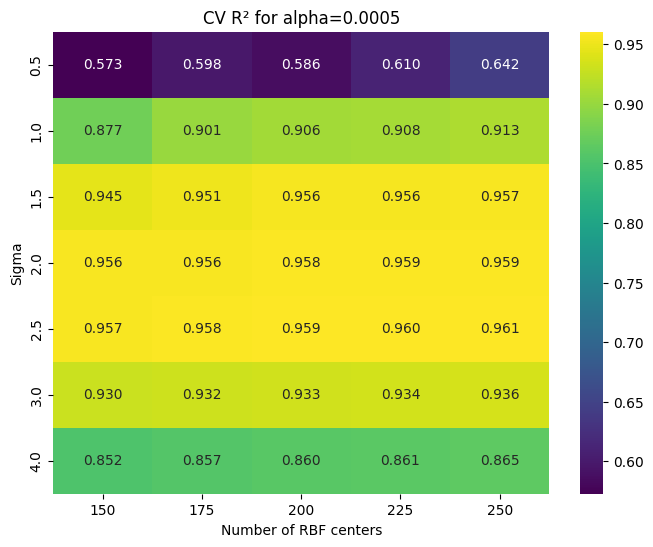

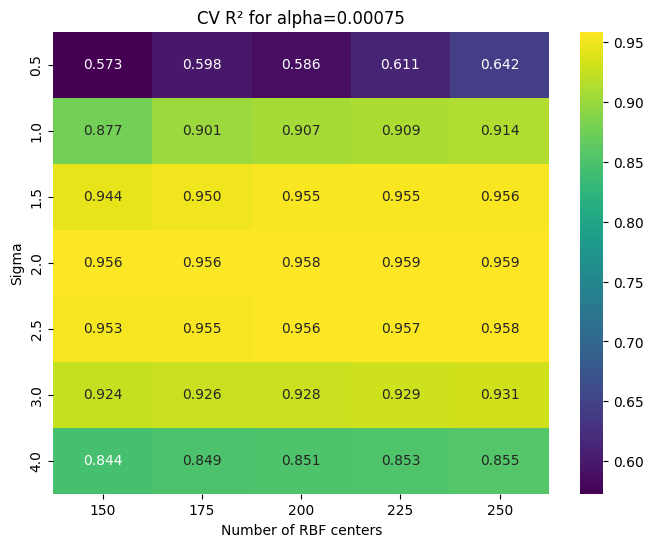

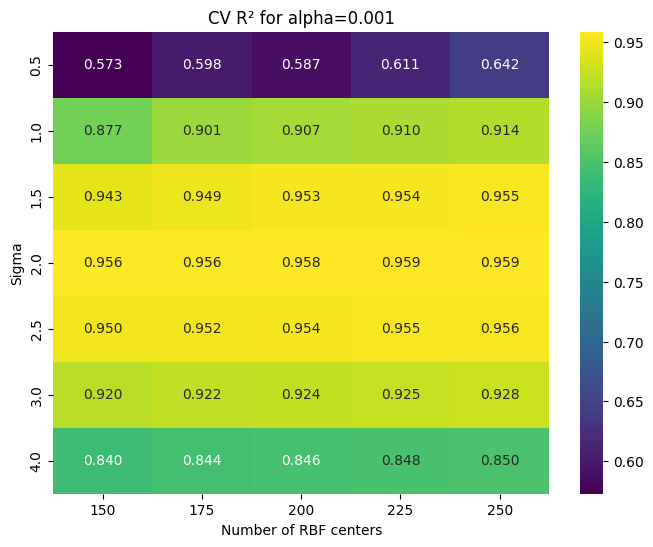

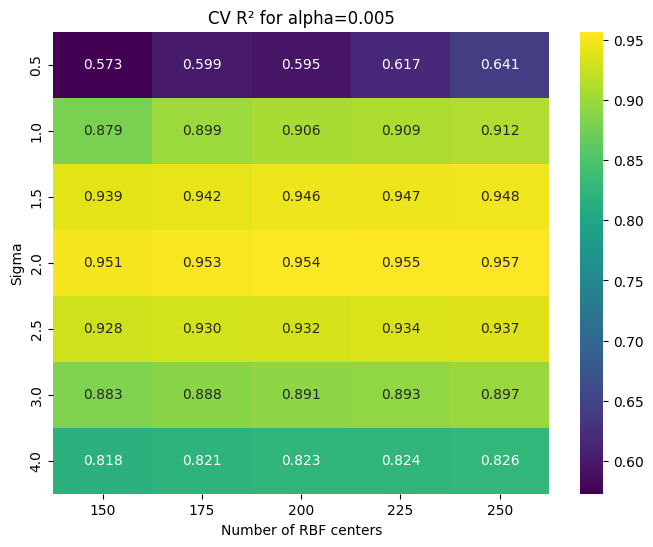

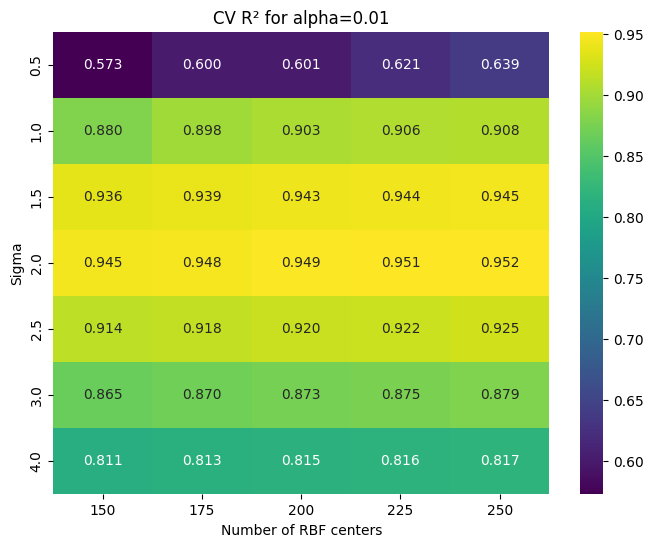

In [119]:
# Convert results to arrays for plotting
sigmas = sigma_list
n_centers_vals = n_centers_list

# Plot heatmaps for each alpha
for alpha in alpha_list:
    heatmap_data = np.zeros((len(sigmas), len(n_centers_vals)))
    
    for i, sigma in enumerate(sigmas):
        for j, n_centers in enumerate(n_centers_vals):
            # find corresponding mean_r2
            for r in results:
                if r['sigma']==sigma and r['n_centers']==n_centers and r['alpha']==alpha:
                    heatmap_data[i, j] = r['mean_r2']
    
    plt.figure(figsize=(8,6))
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", xticklabels=n_centers_vals, yticklabels=sigmas, cmap="viridis")
    plt.title(f"CV R² for alpha={alpha}")
    plt.xlabel("Number of RBF centers")
    plt.ylabel("Sigma")
    plt.show()